# <span style='color:SteelBlue'>P8 - Réalisez un dashboard et assurez une veille technique</span>

# <span style='background:red; color:black'>a MAJ</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des donnees <br>

**Etape 1 : Description des donnees**
- _1/ etc..._


Conclusion

# <span style='background:blue'>Introduction</span>

Ce notebook présente une preuve de concept (POC) pour un nouvelle méthode de classification d'image en Computer Vision.
___

**Source des datasets**<br>
Source : Non précisé<br>

Le dataset est présenté comme un dataset de l'entreprise **"Flipkart"** qui est une entreprise indienne qui souhaite lancer une marketplace e-commerce.

# <span style='background:grey'>Importations des librairies</span>

La cellule ci-dessous permet d'importer les librairies necessaires lors de l'utilisation de Google Colab.

In [1]:
# # pip install pour Google Colab
# %pip install ultralytics

In [2]:
# # Pour Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# print("\nConnecté à Google Drive\n")

Liste des imports généraux :

In [287]:
# Librairies generales
import os.path
import sys
import time
from datetime import datetime
import pyopencl as cl
import pickle
import shutil

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow
import torch
from PIL import Image
from matplotlib import cm

# deep learning
import tensorflow as tf
import sklearn
from sklearn import metrics
from keras.models import load_model, Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
import cv2

# VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from plot_keras_history import show_history
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam

# YOLO
import ultralytics
from ultralytics import YOLO
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")

print("Version des librairies utilisées :")
print("Matplotlib    : " + mpl.__version__)
print("Mlflow        : " + mlflow.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Pytorch       : " + torch.__version__)
print("Scikit-learn  : " + sklearn.__version__)
print("Seaborn       : " + sns.__version__)
print("Tensorflow    : " + tf.__version__)
print("Ultralytics   : " + ultralytics.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Interpréteur python :
Python        : 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]

Version des librairies utilisées :
Matplotlib    : 3.8.4
Mlflow        : 2.10.2
NumPy         : 1.26.4
Pandas        : 1.5.3
Pytorch       : 2.3.0+cpu
Scikit-learn  : 1.2.2
Seaborn       : 0.13.2
Tensorflow    : 2.16.1
Ultralytics   : 8.2.7

Code lance le : 2024-05-07T18:05:56.513016

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# <span style='background:grey'>Paramètres d'affichage</span>

In [4]:
# nombre ligne, col et chiffre apres la virgule
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# Graine aléatoire
random_seed = 42

# Fixer la graine pour Python Numpy et Tensorflow
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Augmenter la limite de pixels à une valeur plus grande
Image.MAX_IMAGE_PIXELS = 1_000_000_000

# <span style='background:grey'>Fonctions</span>


In [5]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée d'éxécution du notebook.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """
    # Calculer la durée totale et convertir en minutes et secondes
    minutes, seconds = divmod(time.time() - start_time, 60)

    # Afficher la durée totale
    print(f"Durée execution notebook : {int(minutes)} min {int(seconds)} sec")

In [6]:
def connect_to_tpu():
    """
    Cette fonction tente de se connecter à un TPU (Tensor Processing Unit)
    disponible.

    Elle utilise l'API TensorFlow pour résoudre un TPU, se connecter à
    celui-ci et l'initialiser.
    Si la connexion est réussie, elle crée une stratégie de distribution
    pour le TPU et affiche un message de confirmation.
    Si la connexion échoue, elle affiche un message d'erreur.

    Lève :
        BaseException: Si aucune connexion TPU n'est disponible.
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Execution sur TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERREUR: Non connecté à un TPU runtime')

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
        print('Connecté à un TPU')
    else:
        print('Pas connecté à un TPU')

In [7]:
def get_available_amd_gpus():
    """
    Cette fonction renvoie une liste des GPU AMD disponibles sur la machine.

    Elle utilise la bibliothèque pyopencl pour obtenir une liste des
    plateformes disponibles, puis vérifie chaque plateforme pour voir si elle
    est fournie par AMD.
    Si c'est le cas, elle vérifie chaque device sur la plateforme pour voir
    s'il s'agit d'un GPU, et si c'est le cas, elle l'ajoute à la liste des GPU.

    Retourne :
        Une liste des objets pyopencl.Device pour les GPU AMD disponibles.
    """
    # Définir le nom du vendeur AMD
    amd_vendor = 'Advanced Micro Devices, Inc.'

    # Obtenir une liste de toutes les plateformes disponibles
    platforms = cl.get_platforms()

    # Initialiser une liste vide pour stocker les GPU AMD
    gpu_devices = [
        device
        for platform in platforms
        if platform.get_info(cl.platform_info.VENDOR) == amd_vendor
        for device in platform.get_devices()
        if device.type == cl.device_type.GPU
        ]

    # Retourner la liste des GPU AMD
    return gpu_devices

In [8]:
def connect_to_local_gpu():
    """
    Cette fonction tente de se connecter aux GPU (Graphics Processing Units)
    AMD disponibles sur la machine locale.

    Elle utilise la fonction `get_available_amd_gpus` pour obtenir une liste
    des GPU AMD disponibles,
    puis affiche un message indiquant que l'exécution se fait sur un PC local
    et le nombre de GPU disponibles.

    """
    amd_gpus = get_available_amd_gpus()
    print("Execution sur PC local")
    print("Nombre de GPU disponible(s) : ", len(amd_gpus), "\n")

In [9]:
def affiche_heatmap(y, nom_y):
    """
    Crée un heatmap des labels y.

    Parameters:
    y (numpy.array): Un array numpy contenant les labels à visualiser.
    nom_y (str): Le nom de la variable y.

    Returns:
    None
    """
    sns.heatmap(y)
    plt.title(f'Heatmap "{nom_y}"')
    plt.xlabel('Catégories')
    plt.ylabel('Image')
    plt.show()

In [10]:
def pretraitement_image_vgg16(data):
    """
    Cette fonction prépare les images pour l'entraînement d'un modèle de
    machine learning  de type VGG-16.

    Paramètres :
    data (DataFrame) : DataFrame contenant les chemins d'accès aux images

    Retourne :
    prepared_images_np (ndarray) : Tableau NumPy des images préparées.
    """

    # Initialisation de la liste pour stocker les images préparées
    prepared_images = []

    # Parcours de chaque chemin d'image dans data
    for image_num in range(len(data)):

        # Chargement et redimensionnement de l'image en 224 x 224 pixels
        img = (load_img(data[image_num], target_size=(224, 224)))

        # Conversion de l'image en tableau NumPy
        img = img_to_array(img)

        # Redimensionnement tableau de l'image pour certifier les 3 dimensions
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Pré-traitement specifique à VGG-16
        img = preprocess_input(img)

        # Ajout de l'image préparée à la liste
        prepared_images.append(img)

    # Conversion de la liste en tableau NumPy
    prepared_images_np = np.array(prepared_images)

    return prepared_images_np

In [11]:
def creer_df_results(history_dict, nb_epoch, nom_model, accuracy_test):
    """
    Cette fonction crée un DataFrame à partir de l'historique de l'entraînement
    du modèle, ajoute les temps d'entraînement, le nombre d'époques comme
    colonnes et le nom du modèle en index.

    Paramètres :
    - history_dict (dict) : Dictionnaire contenant l'historique de
    l'entraînement du modèle optimal et le temps d'exécution
    - nb_epoch (int) : Nombre d'époques d'entraînement
    - nom_model (str) : Nom du modèle.
    - accuracy_test (float) : Précision du modèle sur les données de test.

    Retourne :
    - df_results (df) : DataFrame contenant les résultats du modèle
    """

    df_results = pd.DataFrame(
        {
            'Test Accuracy': accuracy_test,
            'Temps (sec)': history_dict['temps_train'],
            'Epochs': nb_epoch
        },
        index=[nom_model]
    )

    return df_results

In [12]:
def copy_images(X, y, folder, correspondence):
    """
    Copie les images dans les dossiers correspondants.

    Paramètres :
    X : Liste des chemins des images.
    y : Liste des labels correspondants aux images.
    folder : nom dossier où copier les images (par exemple,'train' ou 'val').
    correspondence : df contenant la correspondance entre labels/product_name
    """
    # POUR chaque image et son label
    for image_path, label in zip(X, y):

        # Récupérer le label correspondant (enlever espace à la fin)
        label_str = correspondence.loc[label].index[0].rstrip()

        # Créer le dossier pour le label s'il n'existe pas déjà
        os.makedirs(f'data/cleaned/{folder}/{label_str}', exist_ok=True)

        # Copier l'image dans le dossier correspondant
        shutil.copy(image_path, f'data/cleaned/{folder}/{label_str}')

In [13]:
def conf_mat_transform_argmax(y_true, y_pred):
    """
    Transforme les labels prédits en utilisant la valeur maximale de chaque
    colonne.

    Paramètres:
    y_true (array-like): Les vrais labels.
    y_pred (array-like): Les labels prédits.

    Retourne:
    y_pred_transform (Series): Les labels prédits transformés.
    """

    # Calculer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # Calcule les correspondances (valeurs max de chaque colonne)
    corresp = np.argmax(conf_mat, axis=0)
    print("\nCorrespondance des clusters : ", corresp)

    # Créer un DataFrame avec les vrais labels et les labels prédits
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred

    # Transformer les labels prédits en utilisant la correspondance
    labels['y_pred_transform'] = labels['y_pred'].apply(
        lambda x: corresp[x] if x < len(corresp) else x)

    # Retourner les labels prédits transformés
    return labels['y_pred_transform']

In [14]:
def matrice_conf_et_rapport(y_val_num, y_val_pred_transform, categories):
    """
    Affiche la matrice de confusion pour les valeurs prédites et réelles.

    Paramètres:
    y_val_num (array): Les valeurs réelles.
    y_val_pred_transform (array): Les valeurs prédites.
    categories (list): Les catégories pour les axes de la matrice de confusion.

    Retourne:
    conf_mat_trans_df (DataFrame): La matrice de confusion.
    """
    # Creer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

    # Transformation en dataFrame
    conf_mat_trans_df = pd.DataFrame(
        conf_mat,
        index=[label for label in sorted(categories)],
        columns=[label for label in sorted(categories)]
        )

    # Afficher la matrice de confusion
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat_trans_df, annot=True, cmap="Blues")
    plt.title('Matrice de confusion')
    plt.xlabel('Catégories réelles')
    plt.ylabel('Catégories prédites')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return conf_mat_trans_df

In [15]:
def plot_results_yolo(history_model_yolo):
    """
    Procédure qui trace les courbes de perte (loss) et de précision (accuracy)
    pour le modèle YOLO.

    Paramètres :
    history_model_yolo (dict): Dictionnaire contenant l'historique de
    l'entraînement du modèle YOLO.
    """

    # Récupérer les valeurs de la dernière époque
    train_loss_last = (
        history_model_yolo['history']['             train/loss'].iloc[-1]
    )

    val_loss_last = (
        history_model_yolo['history']['               val/loss'].iloc[-1]
    )

    train_accuracy_last = (
        history_model_yolo['history']['  metrics/accuracy_top1'].iloc[-1]
    )

    # Plot de loss
    plt.figure()
    plt.plot(
        history_model_yolo['history']['                  epoch'],
        history_model_yolo['history']['             train/loss'],
        label=f"Train last value : {train_loss_last:.4f}"
    )

    plt.plot(
        history_model_yolo['history']['                  epoch'],
        history_model_yolo['history']['               val/loss'],
        label=f'Test last value : {val_loss_last:.4f}',
        c='red'
    )

    plt.grid()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(
        history_model_yolo['history']['                  epoch'],
        history_model_yolo['history']['  metrics/accuracy_top1'],
        label=f'Train last value : {train_accuracy_last:.4f}',

    )
    plt.grid()
    plt.title('Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('epochs')
    plt.legend()

    plt.show()

In [142]:
def loss(output):
    """
    Cette fonction calcule la perte pour la 7ème classe du modèle (Watches).

    Args:
        output (numpy.ndarray): Le tableau de sortie du modèle.
        Il est supposé avoir au moins 7 éléments.

    Returns:
        float: La valeur de la perte pour la 7ème classe.
    """
    return output[0][6]

In [144]:
def model_modifier(mdl):
    """
    Modifie la fonction d'activation de la dernière couche d'un modèle en
    linéaire.

    Args:
        mdl (tf.keras.Model): Le modèle à modifier.

    Returns:
        tf.keras.Model: Le modèle avec la fonction d'activation de la dernière
        couche modifiée en linéaire.
    """
    mdl.layers[-1].activation = tf.keras.activations.linear
    return mdl

In [149]:
def afficher_images(img_array, result):
    """
    Affiche l'image originale et la Grad-CAM côte à côte.

    Args:
        img_array (numpy.ndarray): L'image originale à afficher.
        result (numpy.ndarray): L'image Grad-CAM à afficher.

    Returns:
        None
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img_array)
    axs[0].set_title('Originale')
    axs[0].axis('off')

    axs[1].imshow(result)
    axs[1].set_title('Grad-CAM')
    axs[1].axis('off')

    plt.show()

# <span style='background:blue'>Etape 1 : Importation des données</span>

Importation des fichiers CSV avec Pandas

In [16]:
# chemin des fichiers
chemin_data_source = "data/source/"
chemin_data_cleaned = "data/cleaned/"
chemin_model = "modele_ML/"

# Nom du fichier
nom_fichier_brut = "flipkart_com-ecommerce_sample_1050.csv"

# Lire le fichier csv et le stocker dans le dictionnaire
data_brut = pd.read_csv(
    chemin_data_source + nom_fichier_brut,
    sep=",",
    encoding="utf-8"
)
print(f"\n===> fichier '{nom_fichier_brut}' importé: <====\n")

# Apercu du dataframe
display(data_brut)


===> fichier 'flipkart_com-ecommerce_sample_1050.csv' importé: <====



,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'flipkart_com-ecommerce_sample_1050'** contient 15 features 
concernant 1_050 produits vendus sur le site de e-commerce Flipkart.com.
Les textes et images sont libres de droit.
Un dossier contenant les images des produits est associé au fichier CSV.

Les données timestamp ne sont pas dans un format de datetime standard.<br>
Les données de score ne sont pas dans un format de nombre (str ou float).<br>
Il manque le prix d'1 produit et le nom de la marque de 338 produits.<br>

# <span style='background:blue'>Etape 2 : Informations pour le travail</span>

## <span style='background:green'>1/ Disponibilité TPU/GPU</span>

Nous affichons le nombre de TPU/GPU disponibles sur notre machine pour entrainer
le modèle.

In [17]:
# Vérifier si le code est exécuté dans Google Colab
is_google_colab = 'COLAB_GPU' in os.environ
print("Execution in Google Colab : ", is_google_colab, "\n")

# SI Google Colab ALORS Afficher le TPU
if is_google_colab:
    connect_to_tpu()

# Afficher les GPU sur le PC en local
else:
    connect_to_local_gpu()

# Afficher le répertoire courant
print("Current directory :", os.getcwd())

Execution in Google Colab :  False 

Execution sur PC local
Nombre de GPU disponible(s) :  1 

Current directory : c:\Users\pierr\VSC_Projects\Projet8_OCR_DataScientist


## <span style='background:green'>2/ Modèle ML déjà calculé</span>

Nous vérifions si les modèles de ML ont déjà été calculés, auquel cas, il n'est pas nécessaire de les calculer à nouveau mais il suffit de charger les fichiers.

VGG16

In [18]:
# SI fichier history des modèles existe ALORS nous les chargeons
if os.path.exists('./modele_ML/history_model_vgg16.pickle'):
    is_modele_vgg16_calculed = True

    # Modele
    model_vgg16 = load_model('./modele_ML/model_vgg16.keras')

    # History
    with open("./modele_ML/history_model_vgg16.pickle", 'rb') as f:
        history_model_vgg16 = pickle.load(f)

    print("Chargement history_model_vgg16 effectué.")

else:
    is_modele_vgg16_calculed = False
    print("Calcul a faire pour le modèle VGG-16.")

Chargement history_model_vgg16 effectué.


YOLO

In [182]:
# SI fichier history des modèles existe ALORS nous les chargeons
if os.path.exists('./modele_ML/history_model_yolo.pickle'):
    is_modele_yolo_calculed = True

    # Modele
    model_yolo = YOLO('runs/classify/train/weights/best.pt')

    # History
    with open("./modele_ML/history_model_yolo.pickle", 'rb') as f:
        history_model_yolo = pickle.load(f)

    print("Chargement history_model_yolo effectué.")

else:
    is_modele_yolo_calculed = False
    print("Calcul a faire pour le modèle Yolo.")

Chargement history_model_yolo effectué.


# <span style='background:blue'>Etape 3 : Nettoyage des données</span>

Lors d'un précédent projet, nous avons réaliser un nettoyage de ce dataset qui consitait à :
- Sélectionner les 2 features d'intérêt (chemin des fichiers d'images et arborescence de catégorie des produits)
- Détermination de la catégorie du produit à partir de l'arborescence
- Modification du chemin des fichiers d'images pour correspondre à l'arborescence de notre dossier
- Ajout d'une feature 'label' pour la catégorie du produit transformé par un LabelEncoder

Le fichier ainsi nettoyé est enregistré sous le nom **'extraction_feature_image.csv'** est directement utilisé pour la suite de ce projet.

In [20]:
# Nom du fichier
nom_fichier_cleaned = "extraction_feature_image.csv"

# Lire le fichier csv et le stocker dans le dictionnaire
data_cleaned = pd.read_csv(
    chemin_data_cleaned + nom_fichier_cleaned,
    sep="\t",
    encoding="utf-8"
)
print(f"\n===> fichier '{nom_fichier_cleaned}' importé: <====\n")

# Apercu du dataframe
display(data_cleaned)


===> fichier 'extraction_feature_image.csv' importé: <====



,image,product_name,label
0,./data/source/Images/55b85ea15a1536d46b7190ad6...,Home Furnishing,4
1,./data/source/Images/7b72c92c2f6c40268628ec5f1...,Baby Care,0
2,./data/source/Images/64d5d4a258243731dc7bbb1ee...,Baby Care,0
3,./data/source/Images/d4684dcdc759dd9cdf4150469...,Home Furnishing,4
4,./data/source/Images/6325b6870c54cd47be6ebfbff...,Home Furnishing,4
...,...,...,...
1045,./data/source/Images/958f54f4c46b53c8a0a9b8167...,Baby Care,0
1046,./data/source/Images/fd6cbcc22efb6b761bd564c28...,Baby Care,0
1047,./data/source/Images/5912e037d12774bb73a2048f3...,Baby Care,0
1048,./data/source/Images/c3edc504d1b4f0ba6224fa53a...,Baby Care,0


Nous récupérons bien le fichier CSV d'extraction image contenant les informations sur les 1_050 images du dataset :
- le chemin de l'image (nom du fichier inclus)
- le texte de la catégorie de l'image
- le label numérique de la catégorie de l'image

### <span style='background:red; color:black'>DEV début</span>
travail sur échantillion

In [21]:
FRAC = 1

# Faire un échantillon avec FRAC
data_cleaned = data_cleaned.sample(frac=FRAC)

# Apercu du dataframe
display(data_cleaned)

,image,product_name,label
352,./data/source/Images/833a87b0af3b84fe246d2ebf2...,Computers,2
689,./data/source/Images/55195de3873fffaa9e37b0415...,Kitchen & Dining,5
485,./data/source/Images/44b963eb856b4831dfdd21b66...,Computers,2
388,./data/source/Images/98ad5b99ad96695568d8f143b...,Beauty and Personal Care,1
31,./data/source/Images/29b1ca231e10d5269516b80bf...,Watches,6
...,...,...,...
330,./data/source/Images/394c2c627914e1eed9b8ac343...,Computers,2
466,./data/source/Images/3bc98543c7dd0d8fce5b8185b...,Baby Care,0
121,./data/source/Images/7dd5e83e2108a97659577e508...,Baby Care,0
1044,./data/source/Images/be0f39341d771aac57084970f...,Baby Care,0


### <span style='background:red; color:black'>DEV fin</span>


Nous isolons le noms des catégories

In [22]:
categories = data_cleaned['product_name'].unique()
print(categories)

['Computers ' 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Watches ' 'Baby Care ' 'Home Decor & Festive Needs ' 'Home Furnishing ']


# <span style='background:blue'>Etape 4 : Séparation des données</span>

## <span style='background:green'>1/ Détermination target et features</span>

Nous réalisons un apprentissage supervisé pour la classification des images.
Pour cela, nous déterminons la target (valeur à prédire) et les features (paramètres explicatifs de la pédiction) :
- Les **features** (X) sont les chemins des images (nom du fichier inclus) puisque ce sont les données contenues dans les images (pixels) qui vont permettre de prédire la catégorie de l'image

- La **target** (Y) est la colonne "label" puisque c'est la catégorie des images que nous souhaitons prédire

In [23]:
X = data_cleaned['image'].values
y = data_cleaned['label'].values

Nous les affichons les 5 premières valeurs pour vérifier leur contenu.

In [24]:
print(X[:5])

['./data/source/Images/833a87b0af3b84fe246d2ebf271af177.jpg' './data/source/Images/55195de3873fffaa9e37b041533d7305.jpg' './data/source/Images/44b963eb856b4831dfdd21b666593c95.jpg' './data/source/Images/98ad5b99ad96695568d8f143b11ab740.jpg' './data/source/Images/29b1ca231e10d5269516b80bf9d0dffc.jpg']


In [25]:
print(y[:5])

[2 5 2 1 6]


Avant de séparer les données en train et test, nous vérifions la correspondance entre les label et les product_name.

In [26]:
correspondence = (
    data_cleaned.groupby(['label', 'product_name']).size().to_frame('count')
)
display(correspondence)

,,count
label,product_name,
0,Baby Care,150
1,Beauty and Personal Care,150
2,Computers,150
3,Home Decor & Festive Needs,150
4,Home Furnishing,150
5,Kitchen & Dining,150
6,Watches,150


Chaque label correspond bien à une catégorie de produit. Les catégories sont proportionnées de manière équitable.

## <span style='background:green'>2/ train_test_split</span>

Nous divisons les données en 3 jeux de données :
- 75% des données pour le **train**
- 15% des données pour la **validation**
- 15% des données pour le **test**

In [27]:
# Séparation des données (entraînement + validation) / test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=random_seed,
    stratify=y
    )

# Séparation des données entraînement / validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,
    random_state=random_seed,
    stratify=y_temp
    )

# Affichage des dimensions des données
print("X_train shape:", X_train.shape, " / y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, " / y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, " / y_test shape:", y_test.shape)

X_train shape: (735,)  / y_train shape: (735,)
X_val shape: (157,)  / y_val shape: (157,)
X_test shape: (158,)  / y_test shape: (158,)


In [28]:
print(X_train[0:5])

['./data/source/Images/948699ab8c947ce56c256f9cf7996761.jpg' './data/source/Images/0131e5d87b72877702d536299cf83b75.jpg' './data/source/Images/968a2b3be84193e3f755c2fe71033a2c.jpg' './data/source/Images/f12a06b7dbfc55638afafcf8bb03d836.jpg' './data/source/Images/a30aa3b765b613c158fd3a295ed934fa.jpg']


In [29]:
print(y_train[0:5])

[0 5 3 3 4]


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le dataset est équitablement réparti entre 7 catégories. Trois jeux de données ont été crées : train, validation et test. 

# <span style='background:blue'>Etape 5 : Preprocessing des modèles </span>

Avant chaque modélisation, les données doivent être adaptées pour être utiliser par le modèle de machine learning grâce au **preprocessing** des données.

## <span style='background:green'>1/ VGG-16</span>

### <span style='background:black'>a/ target</span>

Le prétraitement de la target consiste à transformer les catégories avec un **OneHotEncoder** pour pouvoir les utiliser dans le modèle de machine learning.

In [30]:
# OneHotEncoder des target d'entrainement, validation et test
y_train_pretraited = to_categorical(y_train)
y_val_pretraited = to_categorical(y_val)
y_test_pretraited = to_categorical(y_test)

Nous visualisons les 3 jeux de données pour vérifier que le prétraitement de la
target a bien été réalisé.

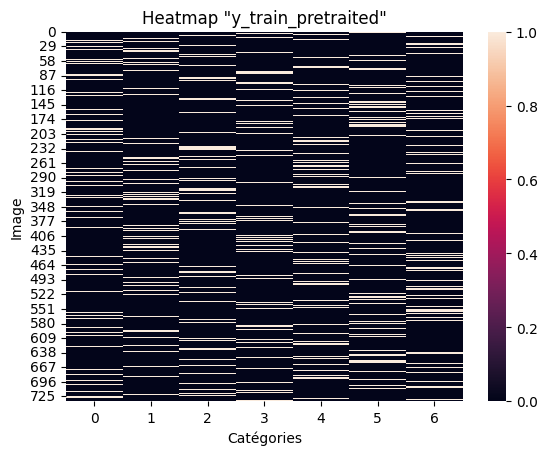

In [31]:
affiche_heatmap(y_train_pretraited, "y_train_pretraited")

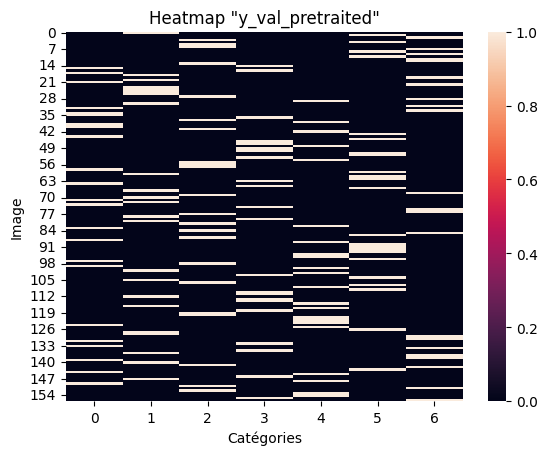

In [32]:
affiche_heatmap(y_val_pretraited, "y_val_pretraited")

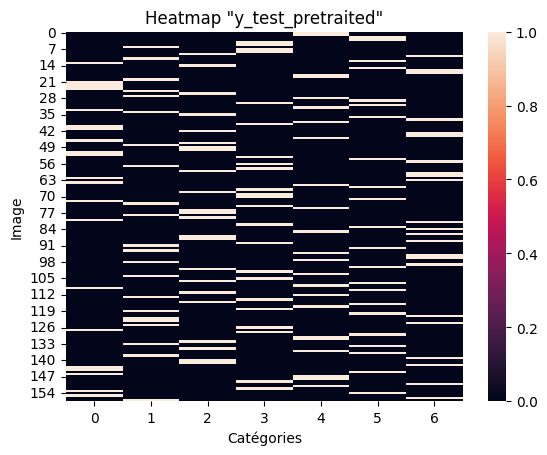

In [33]:
affiche_heatmap(y_test_pretraited, "y_test_pretraited")

### <span style='background:black'>b/ features</span>

Le prétraitement des features pour le **VGG16** se déroule en plusieurs étapes :
- Redimensionnement de l'images en 224 x 224 pixels
- Convertion de l'image en tableau NumPy
- Certification des dimensions (hauteur, largeur, couleur)
- Normaliser les pixels de l'image pour VGG16 :
  - Mettre à l'echelle entre -1 et 1 (soustraire valeur moyenne des
    des pixels sur le canaux RGB du jeu de données ImageNet)
  - inverser les canaux RGB en BGR

In [34]:
# Prétraitement jeu entrainement, validation et test
X_train_pretraited = pretraitement_image_vgg16(X_train)
X_val_pretraited = pretraitement_image_vgg16(X_val)
X_test_pretraited = pretraitement_image_vgg16(X_test)

Nous vérifions les dimensions des images pour vérifier que le prétraitement des features a bien été réalisé.

In [35]:
print("X_train_pretraited : ", X_train_pretraited.shape)
print("X_val_pretraited : ", X_val_pretraited.shape)
print("X_test_pretraited : ", X_test_pretraited.shape)

X_train_pretraited :  (735, 224, 224, 3)
X_val_pretraited :  (157, 224, 224, 3)
X_test_pretraited :  (158, 224, 224, 3)


## <span style='background:green'>2/ YOLO</span>

Le preprocessing pour ce modèle est effectué directement par le processus du modèle. Il consiste à  réaliser : 
- Re-demisionnement de l'image
- Rognage en carré
- Normalisation des valeurs de pixel
- Conversion de l'image en un tenseur

Il nous suffit de classer correctement les images selon une arborescence particulière pour que le modèle réalise correctement les étapes de preprocessing. 

L'arborescence doit être de ce type :

- test
  - catégorie 1
    - fichier image 1
    - fichier image 2
    - ...
  - catégorie 2
  ...

- train
  - catégorie 1
    - fichier image 1
    - fichier image 2
    - ...
  - catégorie 2
  ...

- val
  - catégorie 1
    - fichier image 1
    - fichier image 2
    - ...
  - catégorie 2
  ...

Nous effectuons cette arborescence avec notre dataset.

In [36]:
# Afficher le current directory
print("Current directory :", os.getcwd())

# Créer les dossiers 'train' et 'val' s'ils n'existent pas déjà
os.makedirs('data/cleaned/train', exist_ok=True)
os.makedirs('data/cleaned/val', exist_ok=True)
os.makedirs('data/cleaned/test', exist_ok=True)
print("Dossiers 'train', 'val' et 'test' créés.")

# Copier les images de train et de validation
copy_images(X_train, y_train, 'train', correspondence)
copy_images(X_val, y_val, 'val', correspondence)
copy_images(X_test, y_test, 'test', correspondence)

print("\nImages copiées dans les dossiers 'train', 'val' et 'test'.")

Current directory : c:\Users\pierr\VSC_Projects\Projet8_OCR_DataScientist
Dossiers 'train', 'val' et 'test' créés.

Images copiées dans les dossiers 'train', 'val' et 'test'.


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le **preprocessing** du modèle VGG-16 est réalisé pour les données avant de faire la modélisation. Le modèle Yolo intègre lui directement le preprocessing dans son travail de modélisation, à condition de respecter une arborescence particulière des donnes. 

# <span style='background:blue'>Etape 6 : Entrainement des modèles </span>

Nous entrainons les modèles de machine learning sur les données d'entrainement et de validation.

## <span style='background:green'>1/ VGG-16</span>

### <span style='background:black'>a/ Architecture</span>

Le modèle VGG16 est composé de 16 couches de convolution et de 3 couches fully connected. Il classe les images (224 x 224 pixels) en 1000 catégories différentes.

Nous créons un modèle de classification d'images CNN en réalisant un **transfer learning** à partir du modèle VGG16. Ce dernier est importé **sans** les 3 couches fully connected. Les **poids** du modèle sont initialisés
avec les poids du modèle entrainé sur ImageNet.

Le modèle de transfer learning VGG16 est utilisé comme extracteur de caractéristiques, et 4 nouvelles couches sont ajoutées à sa sortie :
- 1 couche de **GlobalAveragePooling2D** pour convertir les features en un vecteur 1D
- 1 couche **Dense** de 256 neurones et une fonction d'activation **relu**
- 1 couche **Dropout** pour désactiver 50% des neurones
- 1 couche **Dense**
de 7 neurones et une fonction d'activation **softmax** pour la classification


In [37]:
# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_vgg16_calculed:
    print("Les calculs ont deja tournés pour le modèle VGG-16.")
else:
    print("Nous réalisons les calculs.")

    # Récupération du modèle pré-entraîné VGG16 sans les couches supérieures
    base_model_vgg16 = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    # Rendre les couches du modèle VGG16 non entraînables
    for layer in base_model_vgg16.layers:
        layer.trainable = False

    # Récupérer la sortie du modèle VGG16
    x = base_model_vgg16.output

    # Completer model : vecteur 1D / ReLU / desactive moitié / softmax 7 cate
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Créer le nouveau modèle
    model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

Les calculs ont deja tournés pour le modèle VGG-16.



### <span style='background:black'>b/ Compilation et métrique d'évaluation</span>

Le modèle est compilé avec les mêmes paramètres que précedemment, à savoir :
- la fonction de perte '**categorical_crossentropy**'

- l'optimiseur '**rmsprop**'

- la métrique d'évaluation '**accuracy**'

Le nombre d'epoch défini = 10

In [38]:
# Paramètres du modèle
fonction_perte = 'categorical_crossentropy'
optimiseur = 'rmsprop'
metric_eval = 'accuracy'
nb_epoch = 10

# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_vgg16_calculed:
    print("Les calculs ont deja tournés pour le modèle VGG-16.")
else:
    print("Nous réalisons les calculs.\n")

    # Compiler modèle : perte a minimiser / optimiseur / métrique evaluation
    model_vgg16.compile(
        loss=fonction_perte,
        optimizer=optimiseur,
        metrics=[metric_eval]
        )

    # Afficher un résumé du modèle
    print(model_vgg16.summary())

Les calculs ont deja tournés pour le modèle VGG-16.


### <span style='background:black'>c/ Entrainement du modèle</span>

Nous entrainons le modèle avec les données d'entrainement et de validation. Nous ne réalisons pas d'optimisation des hyperparamètres pour réaliser un POC dans un temps relativement court. Les résultats obtenus vont nous permettre d'évaluer les modèles dans leur version 'par défaut'. 

In [39]:
# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_vgg16_calculed:
    print("Les calculs ont deja tournés pour le modèle VGG-16.")
else:
    print("Nous réalisons les calculs.\n")

    # Entraîner le modèle
    start_time = time.time()
    model_vgg16_history = model_vgg16.fit(
        X_train_pretraited,
        y_train_pretraited,
        validation_data=(X_val_pretraited, y_val_pretraited),
        epochs=nb_epoch,
        steps_per_epoch=100,
        verbose=1
    )
    end_time = time.time()

    # Calculer le temps d'entraînement
    temps_train = end_time - start_time
    print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

    # Créer un dictionnaire pour stocker historique, temps et nombre d'époch
    history_model_vgg16 = {
        'history': model_vgg16_history.history,
        'temps_train': temps_train,
    }

    # Sauvegarder le modele entrainé
    model_vgg16.save("./modele_ML/model_vgg16.keras")

    # Sauvegarder l'objet history_dict
    with open("./modele_ML/history_model_vgg16.pickle", 'wb') as f:
        pickle.dump(history_model_vgg16, f)

Les calculs ont deja tournés pour le modèle VGG-16.


## <span style='background:green'>2/ YOLO</span>

### <span style='background:black'>a/ Architecture</span>

### <span style='background:red'>a remplir</span>

Le modèle YOLO v8 utilisé est la version **nano** parmi les 5 disponibles depuis Janvier 2023. Cette version présente une architecture similaire à Yolov5

### <span style='background:red'>fin a remplir</span>


In [40]:
# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_yolo_calculed:
    print("Les calculs ont deja tournés pour le modèle YOLOv8 nano.")
else:
    print("Nous réalisons les calculs\n.")

    # Charger le modèle de classifieur YOLOv8 nano pré-entraîné
    model_yolo = YOLO('yolov8n-cls.pt')

    # Afficher les informations du modèle
    model_yolo.info()

Les calculs ont deja tournés pour le modèle YOLOv8 nano.


### <span style='background:black'>b/ Entrainement du modèle</span>

Nous entrainons le modèle avec les données d'entrainement et de validation.

In [41]:
# Nous réalisons les calculs s'ils n'ont pas été déjà réalisés
if is_modele_yolo_calculed:
    print("Les calculs ont deja tournés pour le modèle YOLOv8 nano.")
else:
    print("Nous réalisons les calculs.\n")

    # Entrainer le modèle YOLO sur les données
    start_time = time.time()
    model_yolo.train(
        data='data/cleaned',
        epochs=nb_epoch
    )
    end_time = time.time()

    # Calculer le temps d'entraînement
    temps_train = end_time - start_time
    print(f"\n=> Temps d'entraînement : {round(temps_train, 2)} sec <=")

    # Acces aux résultats
    results_path = './runs/classify/train/results.csv'
    results_df = pd.read_csv(results_path)

    # Créer un dictionnaire pour stocker historique, temps et nombre d'époch
    history_model_yolo = {
        'history': results_df,
        'temps_train': temps_train,
    }

    # Sauvegarder l'objet history_dict
    with open("./modele_ML/history_model_yolo.pickle", 'wb') as f:
        pickle.dump(history_model_yolo, f)

Les calculs ont deja tournés pour le modèle YOLOv8 nano.


# <span style='background:blue'>Etape 7 : Evaluation des modèles </span>

Pour comparer les performances des différents modèles, nous utilisons 2 indicateurs en mesurant **l'accuracy** et le **temps de calcul** nécessaire pour l'entrainement du modèle. En effet, l'accuracy seule ne suffit pas à déterminer le meilleur modèle, il faut également que celui-ci réalise ses calculs en un minimun de temps.Enfin, nous onbserverons lamatrice de confusion pour comprendre erreurs de prédiction. 

=> Le choix de l'indicateur est donc un compromis entre l'accuracy et le temps de calcul.

## <span style='background:green'>1/ VGG-16</span>

### <span style='background:black'>a/ Accuracy</span>

Nous affichons l'évolution du loss et de l'accuracy au cours de l'entrainement du modèle grâce à l'history. L'évolution de ces 2 métriques avec les données de validation est ici affichée sous le nom 'Test'. 

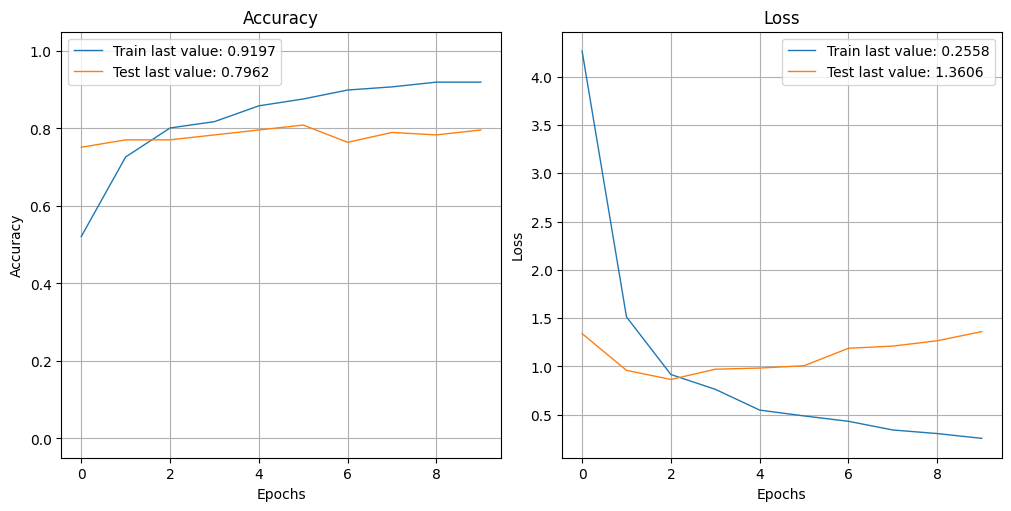

In [42]:
# Afficher l'historique de l'entraînement
show_history(history_model_vgg16['history'])

Nous évaluons ensuite le modèle avec le dataset de test pour obtenir l'accuracy finale du modèle.

In [43]:
# Evaluation meilleur modèle sur les données de test
loss_vgg16_test, accuracy_vgg16_test = (
    model_vgg16.evaluate(X_test_pretraited, y_test_pretraited)
)
print("\nTest Accuracy :  {:.2f}".format(accuracy_vgg16_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8288 - loss: 1.0242

Test Accuracy :  0.84


Le modèle VGG-16 permet d'obtenir une accuracy de test de 0.84.

### <span style='background:black'>b/ Temps d'entrainement</span>

Nous observons le temps néccessaire pour entrainer le modèle permettant d'obtenir ces performances. 

In [44]:
f"Temps entrainement: {history_model_vgg16['temps_train']:.0f} sec"

'Temps entrainement: 579 sec'

### <span style='background:black'>c/ Matrice de confusion</span>

Nous affichons la matrice de confusion pour observer les erreurs de classification du modèle.

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

Correspondance des clusters :  [0 1 2 3 4 5 6]


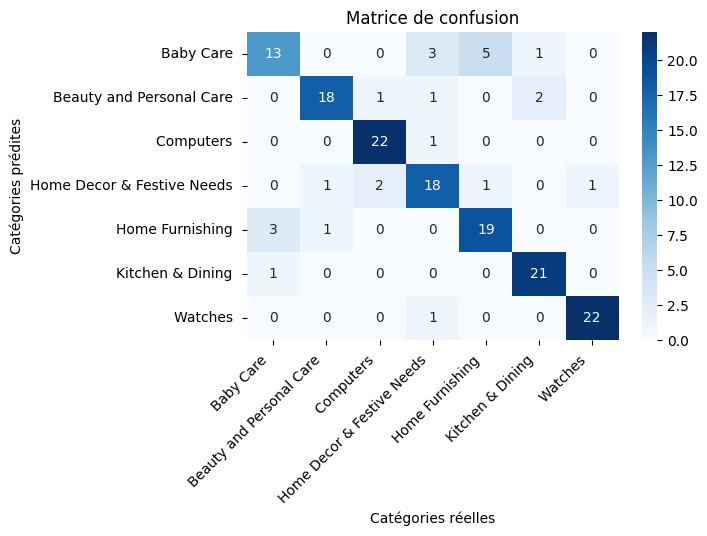

In [45]:
# Categorie réelle et prédites des images de validation
y_test_num = np.argmax(y_test_pretraited, axis=1)
y_test_pred = np.argmax(model_vgg16.predict(X_test_pretraited), axis=1)

# Verifier la correspondance des clusters
y_test_pred_transform = conf_mat_transform_argmax(y_test_num, y_test_pred)

# Afficher la matrice de confusion et le rapport de classification
conf_mat_vgg16 = matrice_conf_et_rapport(
    y_test_num,
    y_test_pred_transform,
    categories
    )

La catégorie pour laquelle le modèle a fait le plus d'erreur est **Home Furnishing** (5 erreurs de prédiction).

## <span style='background:green'>2/ YOLO</span>

### <span style='background:black'>a/ Accuracy</span>

Nous affichons l'évolution du loss et de l'accuracy au cours de l'entrainement du modèle grâce à l'history. L'évolution de ces 2 métriques avec les données de validation est ici affichée sous le nom 'Test'. 

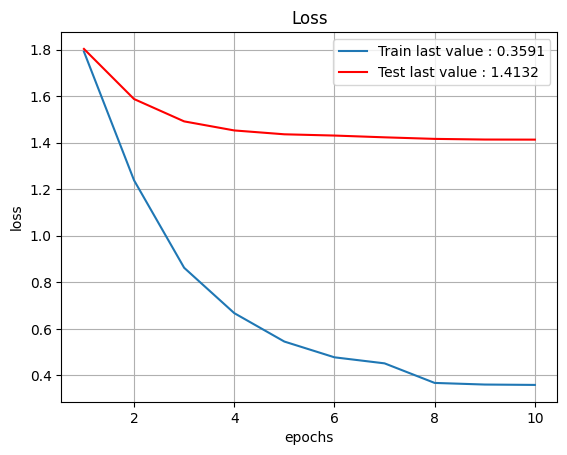

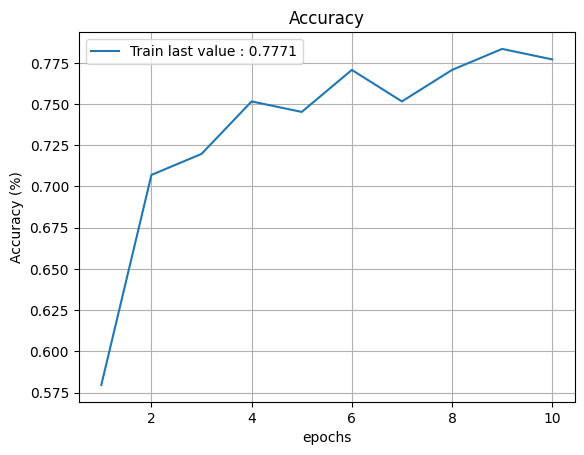

In [46]:
plot_results_yolo(history_model_yolo)

Nous évaluons ensuite le modèle avec le dataset de test pour obtenir l'accuracy finale du modèle.

In [47]:
# charger le modèle YOLO (dernier)
model = YOLO('runs/classify/train/weights/best.pt')

# Evaluer le modèle sur le jeu de test
history_model_yolo['metrics'] = model.val(
    data='validation_on_test_dataset.yaml',
    plots=True,
    save_json=True,
)
print("\nTest Accuracy :  {:.2f}".format(history_model_yolo['metrics'].top1))

Ultralytics YOLOv8.2.7  Python-3.11.5 torch-2.3.0+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
YOLOv8n-cls summary (fused): 73 layers, 1443847 parameters, 0 gradients, 3.3 GFLOPs


val: Scanning C:\Users\pierr\VSC_Projects\Projet8_OCR_DataScientist\data\cleaned\test... 158 images, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


                   all      0.835          1
Speed: 0.0ms preprocess, 5.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to c:\Users\pierr\VSC_Projects\Projet8_OCR_DataScientist\runs\classify\val4

Test Accuracy :  0.84


Le modèle VGG-16 permet d'obtenir une accuracy de test de 0.84.

### <span style='background:black'>b/ Temps d'entrainement</span>

Nous observons le temps néccessaire pour entrainer le modèle permettant d'obtenir ces performances. 

In [48]:
f"Temps entrainement: {history_model_yolo['temps_train']:.0f} sec"

'Temps entrainement: 405 sec'

### <span style='background:black'>c/ Matrice de confusion</span>

Nous affichons la matrice de confusion pour observer les erreurs de classification du modèle.

![Matrice de confusion](runs/classify/val/confusion_matrix.png)

La catégorie pour laquelle le modèle a fait le plus d'erreur est **Home Furnishing** (4 erreurs de prédiction).

# <span style='background:blue'>Etape 8 : Comparaison des résultats </span>


In [49]:
# Regroupement des résultats du modèle VGG16
resultat_vgg16 = creer_df_results(
    history_model_vgg16,
    nb_epoch,
    'vgg16',
    accuracy_vgg16_test
)

# Regroupement des résultats du modèle Yolo
resultat_yolo = creer_df_results(
    history_model_yolo,
    nb_epoch,
    'yolo_v8',
    accuracy_vgg16_test
)

# Assembler resultat_vgg16 et resultat_yolo
df_results = pd.concat([resultat_vgg16, resultat_yolo])
display(df_results)

# Afficher le pourcentage de temps de calcul gagné par Yolo
yolo_time = df_results['Temps (sec)'].loc['yolo_v8']
vgg16_time = df_results['Temps (sec)'].loc['vgg16']
pourcentage_gagne = (1 - yolo_time / vgg16_time) * 100

print(f"Yolo a gagné {pourcentage_gagne:.0f}% de temps de calcul.")

,Test Accuracy,Temps (sec),Epochs
vgg16,0.84,579.20,10
yolo_v8,0.84,405.16,10


Yolo a gagné 30% de temps de calcul.


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le modèle Yolo permet d'obtenir la même accuracy (84%) que le modèle VGG-16 mais plus rapidement car le temps d'entrainement est réduit -30% pour le même nombre d'epoch. 

# <span style='background:blue'>Etape 9 : Analyse des résultats</span>

Au dela de la simple comparaison des performances des modèles, une attention toute particulière est apportée à l'interpretabilité des modèles de classification d'image en deep learning. Cette notion s'apparente à celle connue de "feature importance" en machine learning classique. Elle permet aux humains de comprendre quels sont les données qui ont le plus d'impact sur la prédiction du modèle.

En deep learning, cette notion est plus complexe à appréhender car les données sont des pixels d'images et prédictions finales obtenues sont le résultat de multiples trandformations non linéaires des données d'entrée par les couches du modèle.

Il existe néanmoins des méthodes pour tenter d'interpréter les modèles de deep learning.

## <span style='background:green'>1/ Feature importance locale</span>

La notion de feature importance **locale** permet de comprendre quelles sont les pixels d'une **seule** image qui ont été les plus importants pour la prédiction du modèle pour cette image.

### <span style='background:black'>a/ VGG-16</span>

La méthode **Grad-CAM** (Gradient-weighted Class Activation Mapping) permet de visualiser les régions de l'image qui ont été les plus importantes pour la prédiction du modèle. Elle est souvent utilisée pour les modèles CNN, et donc pour le modèle VGG-16 puisqu'il s'agit d'un CNN avec un transfer learning.

Source : [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [107]:
print(categories)

['Computers ' 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Watches ' 'Baby Care ' 'Home Decor & Festive Needs ' 'Home Furnishing ']


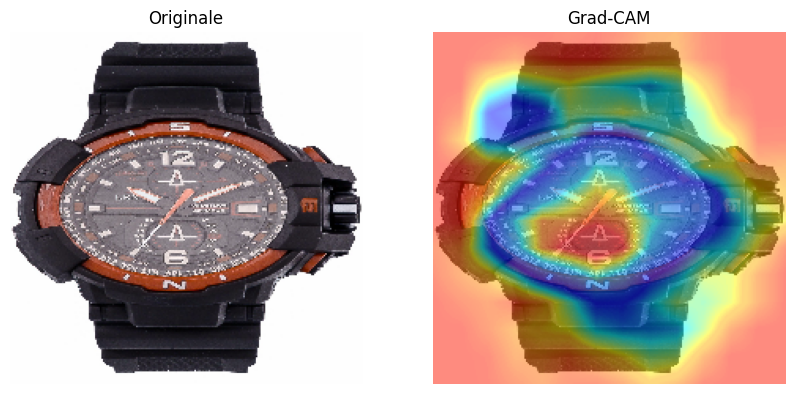

In [151]:
# Chemind'une image choisi au hasard dans le jeu de test
img_path = data_cleaned[4:5]['image']

# Charger l'image
img = load_img(img_path.values[0], target_size=(224, 224))

# Transformation en array et conversion en BGR
img_array = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Application du preprocessing VGG16
X = preprocess_input(img_to_array(img))

# Instanciation de Gradcam avec le modèle VGG16
gradcam = Gradcam(model_vgg16, model_modifier=model_modifier, clone=False)

# Génération de la carte d'activation de classe (dernière couche avant softmax)
cam = gradcam(loss, X, penultimate_layer=-1)

# Normalisation de Gradcam (de 0 à 1)
cam = normalize(cam)

# Création de la Heatmap à partir de l'image
heatmapImg = np.uint8(cm.jet(cam[0])[..., :3] * 255)
heatmapImg = cv2.applyColorMap(heatmapImg, cv2.COLORMAP_JET)

# Superposition de l'image et de la heatmap avec facteur alpha (transparence)
alpha = 0.5
overlay = heatmapImg.copy()
result = cv2.addWeighted(img_array, alpha, heatmapImg, 1 - alpha, 0)

# Affichage de l'image originale et de la Gradcam
afficher_images(img_array, result)

Sur l'image de droite, nous remarquons les régions de l'image qui ont été les plus importantes pour la prédiction de la catégorie de l'image. En effet, les régions en rouge sont celles qui ont été les plus importantes et celles en bleu ont été les moins importantes.

### <span style='background:black'>b/ YOLO</span>

Parler de Eigen CAM

Source : [Eigen-CAM: Class Activation Map using Principal Components](https://arxiv.org/abs/2008.00299)

0: 224x224 Watches 1.00, Home Decor & Festive Needs 0.00, Computers 0.00, Beauty and Personal Care 0.00, Baby Care 0.00, 113.1ms
Speed: 15.0ms preprocess, 113.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


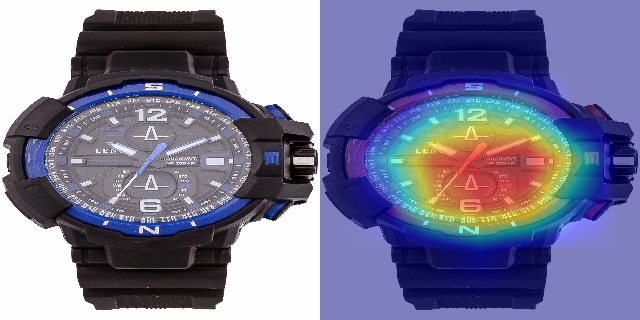

In [286]:
# If img_path is a Series, get the first value from it
if isinstance(img_path, pd.Series):
    img_path = img_path.iloc[0]

# Chargement, redimensionnement, copie, normalisation, Conversion BGR image
img = cv2.imread(img_path)
img = cv2.resize(img, (320, 320))
rgb_img = img.copy()
img = np.float32(img) / 255
img_bgr = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)

# Récupération de l'avant-dernière couche
target_layers = [model_yolo.model.model[-2]]

# Superposition de la EigenCAM sur l'image
cam = EigenCAM(model_yolo, target_layers, task='cls')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# Affichage de l'image originale et de la EigenCAM
Image.fromarray(np.hstack((img_bgr, cam_image)))

Expliquer pourquoi les couleurs sur l'image...

Il existe encore d'autre methode avec Randomized Image Sampling for Explanations (RISE)

Source : [RISE: Randomized Input Sampling for Explanation of Black-box Models](https://arxiv.org/abs/1806.07421)

## <span style='background:green'>2/ Feature importance globale</span>


# <span style='background:blue'>Conclusion</span>


In [51]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée execution notebook : 1 min 0 sec


Réaliser une veille sur les outils et tendances en data science et IA afin de mettre à jour son expertise et de s’assurer que les méthodes utilisées mobilisent bien les techniques en vigueur 

~~- CE1 Vous avez consulté des sources reconnues d'informations, produites récemment (blogs reconnus, articles de recherche de journaux et conférences reconnues dans le domaine).~~
- CE2 Vous avez présenté les points clés de chacune des sources bibliographiques, y compris des détails mathématiques.
- CE3 Vous avez mis en place une preuve de concept pour tester le nouvel outil / le nouveau modèle, la nouvelle démarche, et le comparer à une approche classique.